In [ ]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from scipy import ndimage as nd
import MyDifferentialEvolution as DE

# IMPORTANTE: PARA PODER VISUALIZAR MEJOR EL RESULTADO, UTILICÉ UNA IMAGEN MÁS OSCURA QUE LA ORIGINALMENTE PROPORCIONADA

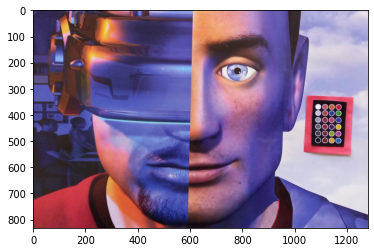

In [ ]:
img = cv2.imread('imagen.jpeg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
plt.figure()
plt.imshow(img)
plt.show()


# Aplicar filtros para quedarnos con una máscara de los colores de interés

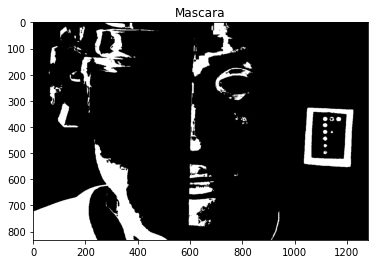

In [ ]:
m1 = np.uint8(np.logical_or(hsv[:,:,0]<10,hsv[:,:,0]>170))
m2 = np.uint8(np.logical_and(hsv[:,:,1]>100,hsv[:,:,2]>100))
m = cv2.bitwise_and(m1,m2)

plt.figure()
plt.title('Mascara')
plt.imshow(m,cmap="gray")
plt.show()


# Aplicar operaciones morfológicas para eliminar las áreas no deseadas

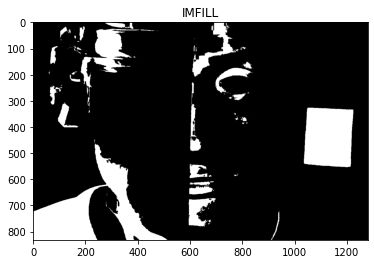

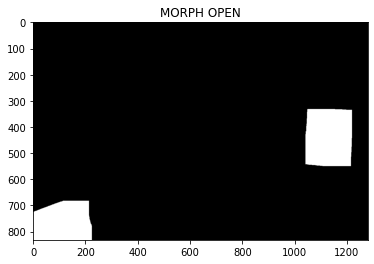

In [ ]:
mFilled = nd.binary_fill_holes(m)
plt.figure()
plt.title('IMFILL')
plt.imshow(mFilled,cmap="gray")
plt.show()

strel = cv2.getStructuringElement(cv2.MORPH_RECT,(100,100))
mFilled = cv2.morphologyEx(np.uint8(mFilled),cv2.MORPH_OPEN,strel)

plt.figure()
plt.title('MORPH OPEN')
plt.imshow(mFilled,cmap="gray")
plt.show()



# Detectar cuántos lados tienen las dos figuras restantes de la máscara, nos quedamos con la que tenga la menor cantidad de lados

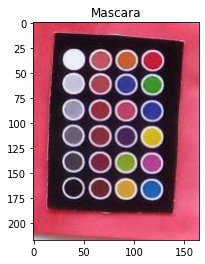

In [ ]:
imagecontours, _ = cv2.findContours(mFilled, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
min = 9999
for i in imagecontours:
  epsilon = 0.01 * cv2.arcLength(i, True)
  approximations = cv2.approxPolyDP(i, epsilon, True)
  lenAp=len(approximations)
  if lenAp < min:
    minVertices = approximations
    min = lenAp
  
crop_img = img[minVertices[0][0][1]:minVertices[2][0][1],minVertices[0][0][0]:minVertices[2][0][0]]
plt.figure()
plt.title('Mascara')
plt.imshow(crop_img,cmap="gray")
plt.show()

# Obtener los círculos de la imagen resultante

In [ ]:
def get_circles(imgN):
  gray = cv2.cvtColor(imgN,cv2.COLOR_RGB2GRAY)
  circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT,1,10,param1=100,param2=25,minRadius=2,maxRadius=20)
  if circles is None or len(circles[0])<24:
    gray = cv2.medianBlur(gray,5)
    circles=cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT,1,10,param1=100,param2=30,minRadius=10,maxRadius=40)

  if circles is None or len(circles[0])<24:
    print('ERROR')

  circles = np.uint16(np.around(circles))
  return circles

In [ ]:
circles = get_circles(crop_img)
circles = circles.reshape(24,3)
circles[:,0]
idx = np.argsort(circles[:,0])
circles = circles[idx]

columns = []
col1 = circles[:6,:]
col2 = circles[6:12,:]
col3 = circles[12:18,:]
col4 = circles[18:24,:]
columns.append(col1)
columns.append(col2)
columns.append(col3)
columns.append(col4)

for i in range(len(columns)):
  idx = np.argsort(columns[i][:,1])
  columns[i] = columns[i][idx]

colorPalette = []
for col in columns:
  paletteI=[]
  for circle in col:
    img_circle = crop_img[ circle[1]-circle[2]//2 : circle[1]+circle[2]//2, circle[0]-circle[2]//2 : circle[0]+circle[2]//2 , : ]
    R = np.median(img_circle[:,:,0])
    G = np.median(img_circle[:,:,1])
    B = np.median(img_circle[:,:,2])
    paletteI.append([R,G,B])
  colorPalette.append(paletteI)

colorPalette = np.array(colorPalette)   
colorPalette = colorPalette.reshape(24,3)

# Obtener los círculos de la paleta de calibración



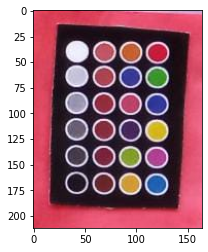

In [ ]:
imgCal = cv2.imread('imagen_cal.png')
imgCal = cv2.cvtColor(imgCal,cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(imgCal)
plt.show()

In [ ]:

circles = get_circles(imgCal)

circles = circles.reshape(24,3)
circles[:,0]
idx = np.argsort(circles[:,0])
circles = circles[idx]

columns = []
col1 = circles[:6,:]
col2 = circles[6:12,:]
col3 = circles[12:18,:]
col4 = circles[18:24,:]
columns.append(col1)
columns.append(col2)
columns.append(col3)
columns.append(col4)

for i in range(len(columns)):
  idx = np.argsort(columns[i][:,1])
  columns[i] = columns[i][idx]

calibrationPalette = []
for col in columns:
  paletteI=[]
  for circle in col:
    img_circle = imgCal[ circle[1]-circle[2]//2 : circle[1]+circle[2]//2, circle[0]-circle[2]//2 : circle[0]+circle[2]//2 , : ]
    R = np.median(img_circle[:,:,0])
    G = np.median(img_circle[:,:,1])
    B = np.median(img_circle[:,:,2])
    paletteI.append([R,G,B])
  calibrationPalette.append(paletteI)

calibrationPalette = np.array(calibrationPalette)   
calibrationPalette = calibrationPalette.reshape(24,3)


# Visualizar los colores de ambas paletas

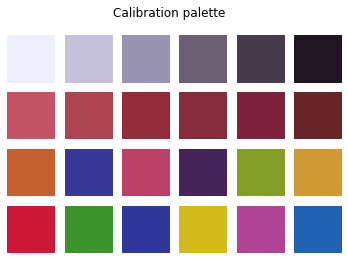

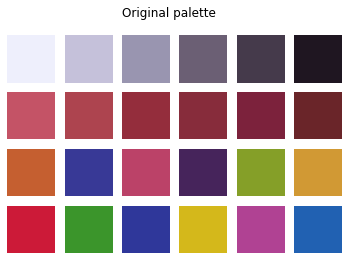

In [ ]:
colorBlock = np.zeros_like(img_circle)
plt.figure()
plt.suptitle('Calibration palette')
for i in range(len(calibrationPalette)):
  colorBlock[:,:,0] = calibrationPalette[i][0]
  colorBlock[:,:,1] = calibrationPalette[i][1]
  colorBlock[:,:,2] = calibrationPalette[i][2]
  
  plt.subplot(4,6,i+1)
  plt.imshow(colorBlock)
  plt.axis('off')
plt.show()

colorBlock = np.zeros_like(img_circle)
plt.figure()
plt.suptitle('Original palette')
for i in range(len(colorPalette)):
  colorBlock[:,:,0] = colorPalette[i][0]
  colorBlock[:,:,1] = colorPalette[i][1]
  colorBlock[:,:,2] = colorPalette[i][2]
  
  plt.subplot(4,6,i+1)
  plt.imshow(colorBlock)
  plt.axis('off')
plt.show()


# Aplicando evolución diferencial para resolver el problema

In [ ]:
def individual_fitness(ind,calibrationPalette,colorPalette):
  ind = ind.reshape(3,3)
  eval = np.matmul(colorPalette,ind)
  return np.linalg.norm(calibrationPalette-eval)

In [ ]:
b = [[0,100],
     [0,100],
     [0,100],
     [0,100],
     [0,100],
     [0,100],
     [0,100],
     [0,100],
     [0,100]]
res = DE.differential_evolution(individual_fitness,bounds=b,args=(calibrationPalette,colorPalette),N=200,g=4000,early_stopping_generations=100)
print("------SOLUTION------")
print(res[0])
print("------FITNESS------")
print(res[1])
print()
calMatrix = res[0].reshape(3,3)
print("CALIBRATION MATRIX")
print(calMatrix)

------SOLUTION------
[9.97046297e-01 1.17615904e-03 4.17225642e-05 1.93835170e-04
 9.99379186e-01 1.48824529e-03 2.02633465e-03 1.85730015e-04
 9.98726316e-01]
------FITNESS------
3.8973474173392577

CALIBRATION MATRIX
[[9.97046297e-01 1.17615904e-03 4.17225642e-05]
 [1.93835170e-04 9.99379186e-01 1.48824529e-03]
 [2.02633465e-03 1.85730015e-04 9.98726316e-01]]


(1064960, 3)


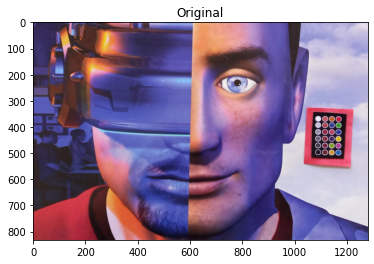

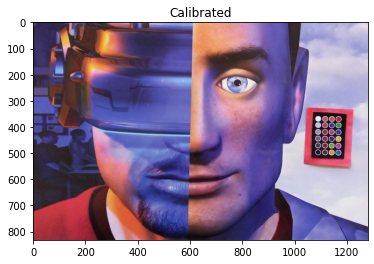

In [ ]:
nrows,ncols,_= img.shape
Ximg = img.reshape((nrows*ncols),3)
print(Ximg.shape)

Ximg = np.matmul(Ximg,calMatrix).astype(int)
Ximg = Ximg.reshape(nrows,ncols,3)


plt.figure()
plt.title("Original")
plt.imshow(img)
plt.show()

plt.figure()
plt.title("Calibrated")
plt.imshow(Ximg.astype(np.uint8))
plt.show()
